# Raƒçunalni≈°ki vid v robotiki

Da uspe≈°no opravite vajo, jo morate predstaviti asistentu na vajah. Pri nekaterih nalogah so vpra≈°anja, ki zahtevajo skiciranje, roƒçno raƒçunanje in razmislek. Konƒçno re≈°itev na tak≈°na vpra≈°anja vpi≈°ite v predvideni prostor, postopek re≈°evanja pa razlo≈æite asistentu na vajah. Deli nalog, ki imajo pred navodilom navedene toƒçke, niso obvezni. Brez njih lahko za celotno vajo dobite najveƒç **75** toƒçk (zgornja meja je **100** toƒçk kar pomeni oceno 10). V nekaterih vajah je dodatnih nalog veƒç in vam ni potrebno opraviti vseh.

Zakljuƒçna vaja povezuje robotiko in raƒçunalni≈°ko zaznavanje. Va≈° robotski sistem boste nadgradili s kamero, ki bo opazovala delovno povr≈°ino robotskega manipulatorja, preko zajete slike pa boste lahko na povr≈°ini zaznali objekte glede na njihovo barvo in obliko. Preko homografske preslikave boste toƒçke iz koordinatnega prostora slike pretvorili v prostor robota ter mu ukazali, naj se premakne tako, da poka≈æe na ustrezni predmet.

In [2]:
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

%matplotlib notebook

In [4]:
# Run this cell to download the data used in this exercise
import zipfile, urllib.request, io
zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("https://data.vicos.si/lukacu/rrz/vaja4.zip").read())).extractall()

## Naloga 1 - Homografska transformacija

Homografska transformacija je pogosto uporabljana v projektivni geometriji. Predstavlja projekcijo ene ravnine v prostoru na drugo ravnino v prostoru. Naj bo $\mathbf{x}_w$ toƒçka na ravnini v svetovnih koordinatah in naj bo $\mathbf{x}_c$ toƒçka v koordinatah slikovne ravnine. Natanƒçneje, $\mathbf{x}_w=[ x_w, y_w, 1 ]^T$ in $\mathbf{x}_c=[ x_c, y_c, 1 ]^T$. Projekcijo toƒçke svetovnih koordinatah $\mathbf{x}_w$ v toƒçko $\mathbf{x}_c$, ki se nahaja na slikovni ravnini senzorja, preslikamo s homografijo $\mathbf{H}_w^c$ po enaƒçbi

$$
    \mathbf{x}_c = \lambda \mathbf{H}_w^c \mathbf{x}_w,
$$

kjer je homografija matrika velikosti $3 \times 3$ elementov

$$
    \mathbf{H}_w^c = \left[ {\begin{array}{}
{{h_{11}}}&{{h_{12}}}&{{h_{13}}}\\
{{h_{21}}}&{{h_{22}}}&{{h_{23}}}\\
{{h_{31}}}&{{h_{32}}}&{{h_{33}}}
\end{array}} \right] .
$$

Relacija v zgornji enaƒçbi je zapisana v homogenih koordinatah in je zato napisana le do skale natanƒçno. V praksi ima matrika $\mathbf{H}_w^c$ samo 8 *prostih* parametrov in ne 9, saj zadnji element postavimo na ena, $h_{33}=1$. ƒåe hoƒçemo toƒçke v koordinatah slike $\mathbf{x}_c$ preslikati v toƒçko $\mathbf{x}_c$, ki se nahaja na svetovnih koordinatah, moramo uporabiti inverz homografije $\mathbf{H}_c^w = (\mathbf{H}_w^c)^{-1}$.

V naslednjih nalogah boste preizkusili homografsko transformacijo na pripravljenih podatkih.

* Nalo≈æite sliko iz datoteke ``camera1.jpg`` ter homografsko matriko iz datoteke ``camera1.txt`` z uporabo spodaj prilo≈æene funkcije ``load_h``. Prika≈æite sliko ter na njej izri≈°ite mre≈æo toƒçk z desetimi vrsticami in desetimi stolpci.

In [2]:
def load_h(txt_file_path):
    with open(txt_file_path, 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]    
    return np.array(l)

<IPython.core.display.Javascript object>


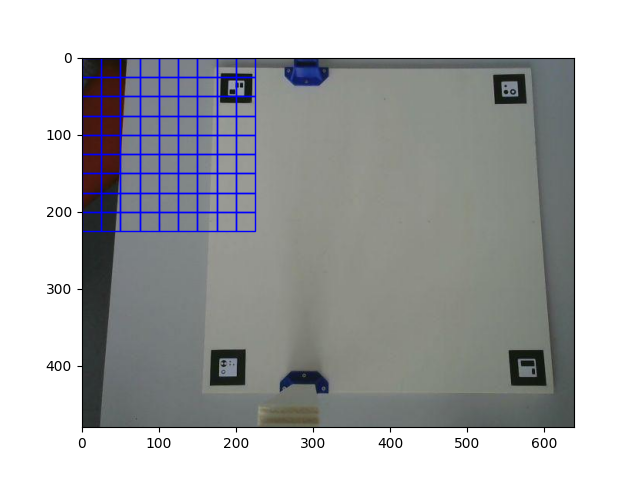

In [28]:
import matplotlib.patches as patches
h = load_h("camera1.txt")
img = cv2.imread("camera1.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(im)
coords = []
x = 0
y=0
for i in range(1,10):
    for j in range(1,10):
        rect = patches.Rectangle((x,y), 25, 25, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        x+=25
        coords.append((x,y))
    y+=25
    x=0
plt.show()


* Izris spremenite tako, da toƒçke ƒçrt pred izrisom preslikate s prebrano homografsko matriko. Pri tem morate toƒçke najprej preslikati v homografske koordinate (na konec vektorja dodati vrednost $1$), jo pomno≈æiti z matriko, nato pa *toƒçko pretvoriti nazaj iz homogenih koordinat* tako, da vektor delimo z vrednostjo zadnjega elementa ter tega nato odstranimo. Spodaj je prikazan za≈æeleni rezultat, kjer plava mre≈æa prikazuje rezultat zgornje naloge, rdeƒça mre≈æa pa rezultat te naloge.

\begin{equation*}
p_S = [ x, y, 1 ], \\  p_H = H \ast p_S = [ x_H, y_H, z_H ], \\ p_D = \big[ \frac{x_H}{z_H}, \frac{y_H}{z_H} \big]
\end{equation*}

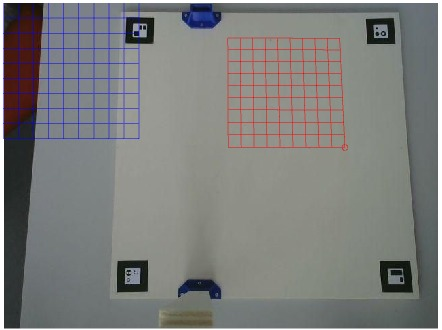

<IPython.core.display.Javascript object>


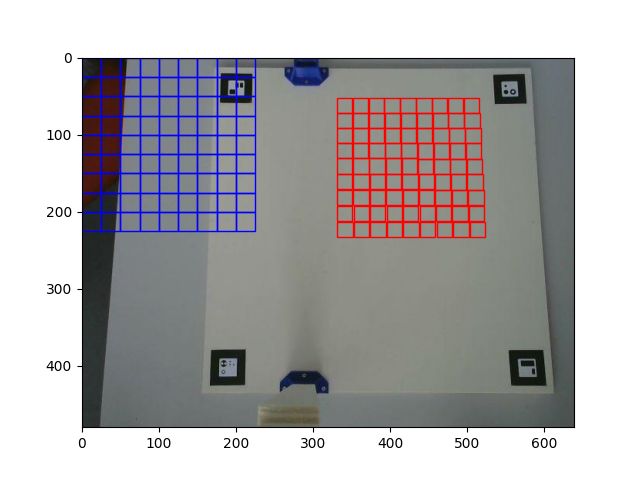

In [7]:

import matplotlib.patches as patches
h = load_h("camera1.txt")
img = cv2.imread("camera1.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(im)
coords = []
x = 0
y=0
for i in range(1,10):
    for j in range(1,10):
        rect = patches.Rectangle((x,y), 25, 25, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        coords.append((x,y))
        x+=25
    y+=25
    x=0
for i in coords:
    ps = np.array([i[0],i[1],1])
    ph = np.dot(h,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    rect = patches.Rectangle((pd[0],pd[1]), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

* Oglejmo si sedaj ≈°e preslikavo v drugo smer. To tehniko lahko uporabimo za preslikavo iz slikovnih koordinat v svetovne koordinate. Matriko $H$ invertirajte z uporabo funkcije ``np.linalg.inv``. Prika≈æite sliko ter z uporabo funkcije ``ginput`` knji≈ænice *matplotlib* vnesite eno ali veƒç toƒçk s klikom na sliko. Dane toƒçke preslikajte z uporabo inverza matrike $H$ iz ravnine kamere v svetovne koordinate ter jih prika≈æite v novem grafu z uporabo funkcije plot.

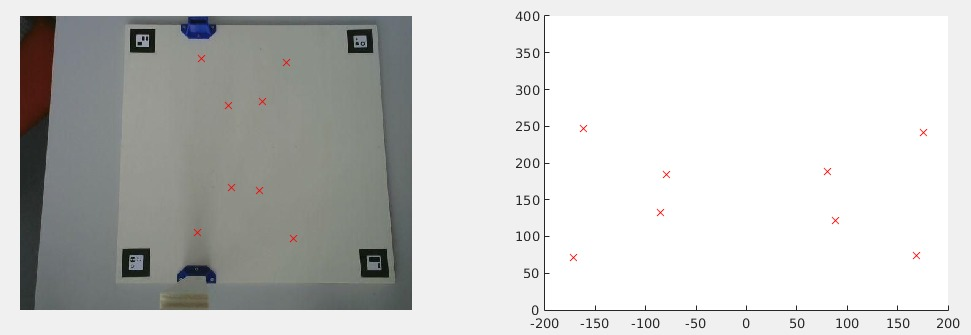

In [ ]:
# TODO
h = load_h("camera1.txt")
img = cv2.imread("camera1.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure()
plt.subplot(121)
plt.imshow(im)
x = plt.ginput(8,show_clicks=True)
hi = np.linalg.inv(h)
xx=[]
xy=[]
tx = []
ty = []
for i in x:
    xx.append(i[0])
    xy.append(i[1])
    ps = np.array([i[0],i[1],1])
    ph = np.dot(hi,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    tx.append(pd[0])
    ty.append(pd[1])
plt.scatter(xx,xy,marker="+", c="r")
plt.subplot(122)
plt.scatter(ty,tx,marker="x",c="r")
plt.show()

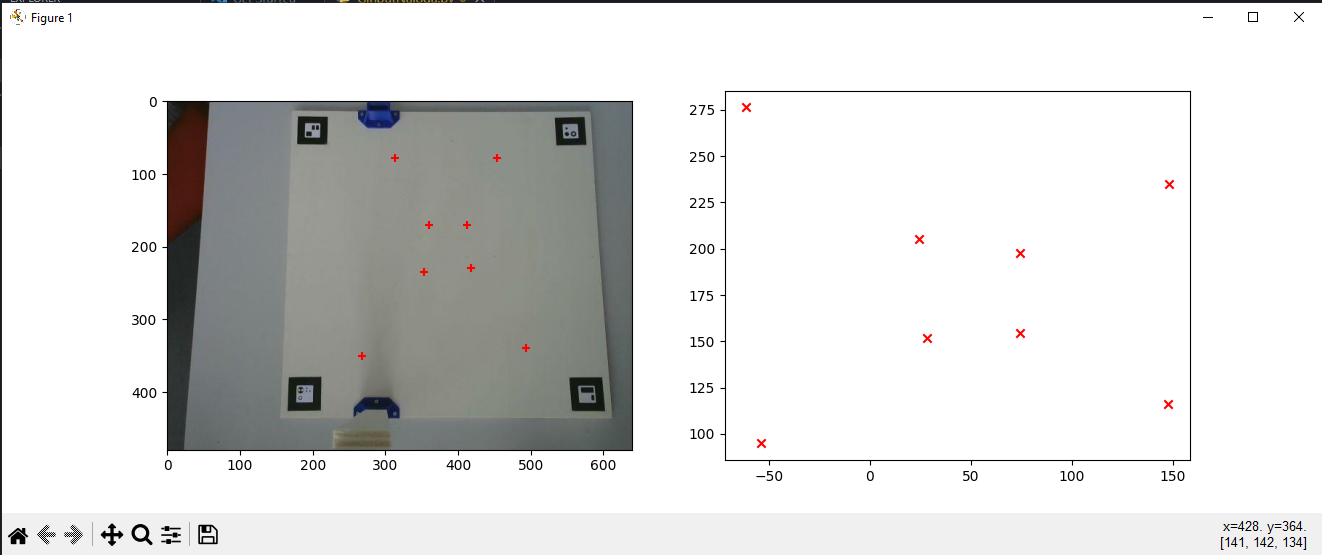

## Naloga 2 - Detekcija objektov

V tej nalogi boste implementirali preprosto detekcijo planarnih objektov z uporabo segmentacije, morfolo≈°kih operacij ter opisa regij. Sledite naslednjim korakom (*lahko si pomagate z detekcijo bombonov, ƒçe ste jo implementirali v okviru druge vaje*).

* Nalo≈æite sliko iz datoteke ``camera2.jpg`` ter jo prika≈æite na zaslonu. Z uporabo funkcije ``ginput`` doloƒçite meje poligona delovne povr≈°ine kot je prikazano na spodnjem primeru. Nato za podane toƒçke generirajte rastersko masko z uporabo funkcije ``poly2mask``, ki na vhodu sprejme koordinate poligona ter velikost rasteriziranega obmoƒçja (za la≈æjo uporabo naj bo ta enaka velikosti slike). ƒåe ste pri drugi vaji implementirali funkcijo ``immask``, jo sedaj uporabite za prikaz izolirane delovne povr≈°ine.

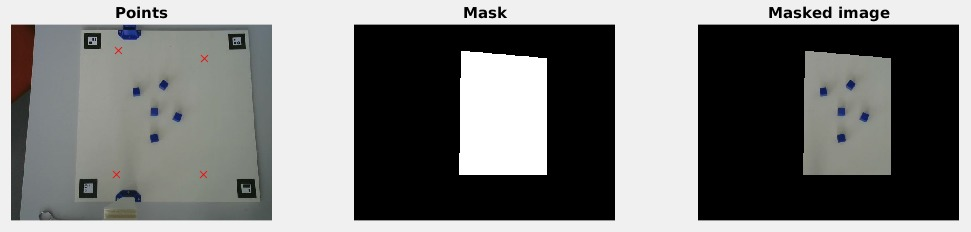

In [9]:
from skimage import draw
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [10]:
def im_mask(I, mask):
    # Zapi≈°ite re≈°itev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0
    
    return I_masked

In [ ]:
img = cv2.imread("camera2.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
for i in x:
    x_c.append(i[0])
    y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)
plt.subplot(132)
plt.imshow(mask,cmap="gray")
plt.subplot(133)
imm = im_mask(im,mask)
plt.imshow(imm)
plt.show()

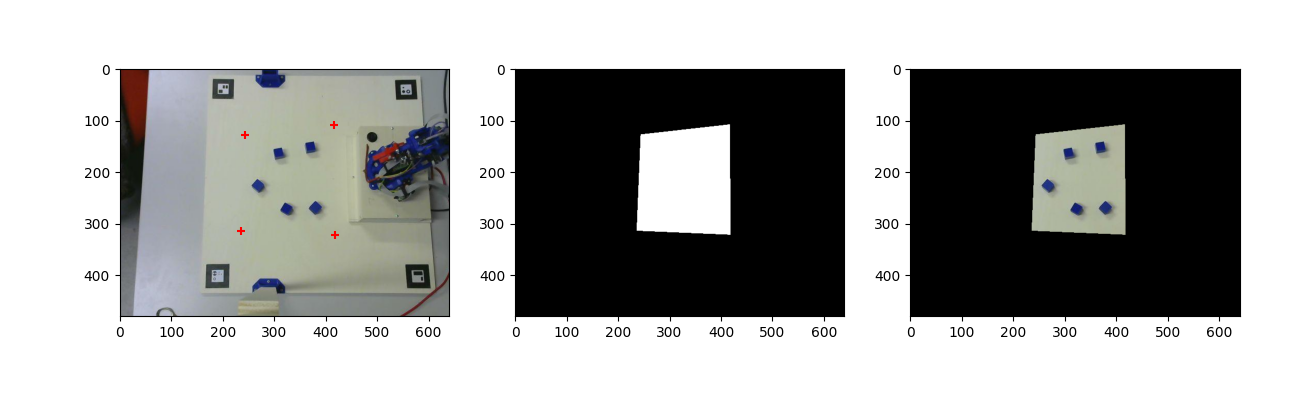

* Sliko pogleda kamere pretvorite v HSV barvni prostor ter z uporabo upragovanja doloƒçite regije modre barve. Po potrebi segmentacijo izbolj≈°ajte z uporabo morfolo≈°kih operacij *erode* in *dilate*, da se znebite ≈°uma. Konƒçno binarno masko zdru≈æite z masko delovne povr≈°ine, da odstranite morebitne napaƒçne detekcije.

In [ ]:
from skimage import draw
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    # Zapi≈°ite re≈°itev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0   
    return I_masked
img = cv2.imread("camera2.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
for i in x:
    x_c.append(i[0])
    y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)
imm = im_mask(im,mask)
hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>90:
            imm[i][j]=0
plt.subplot(132)
plt.imshow(imm,cmap="gray")
plt.subplot(133)
plt.imshow(im_mask(im,imm))
plt.show()

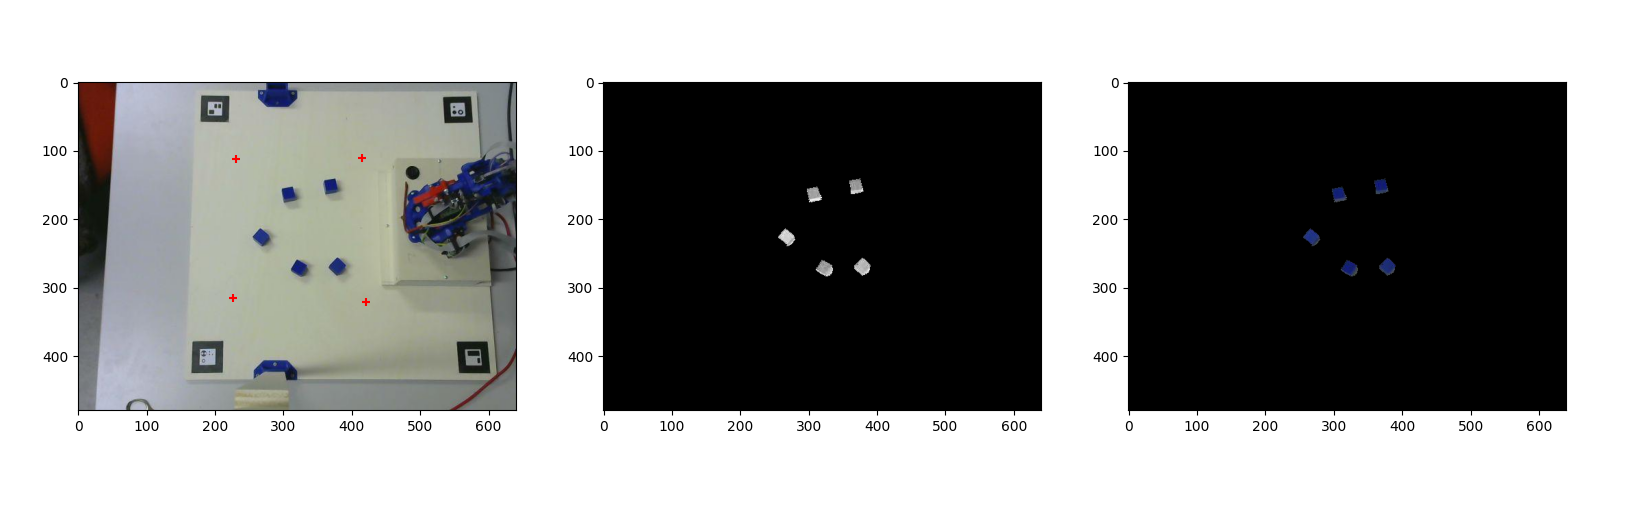

* Masko razdelite na posamezne komponente. Za vsako komponento izraƒçunajte centroid, ki jih nato prika≈æite kot toƒçke na izvorni sliki iz datoteke ``camera2.jpg``.

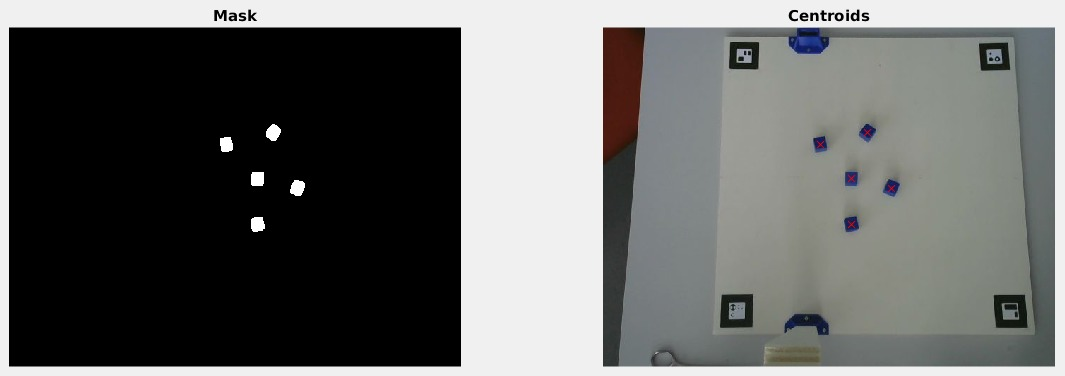

In [ ]:
from skimage import draw
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    # Zapi≈°ite re≈°itev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0
    
    return I_masked
img = cv2.imread("camera2.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
for i in x:
    x_c.append(i[0])
    y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)

imm = im_mask(im,mask)

hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>90:
            imm[i][j]=0

plt.subplot(132)

ret,th1 = cv2.threshold(imm,0,100,cv2.THRESH_BINARY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)

plt.imshow(imm,cmap="gray")
plt.subplot(133)
for i in range(3,len(centroids)):
    plt.scatter(centroids[i][0],centroids[i][1], color = "red")
plt.imshow(im)
plt.show()

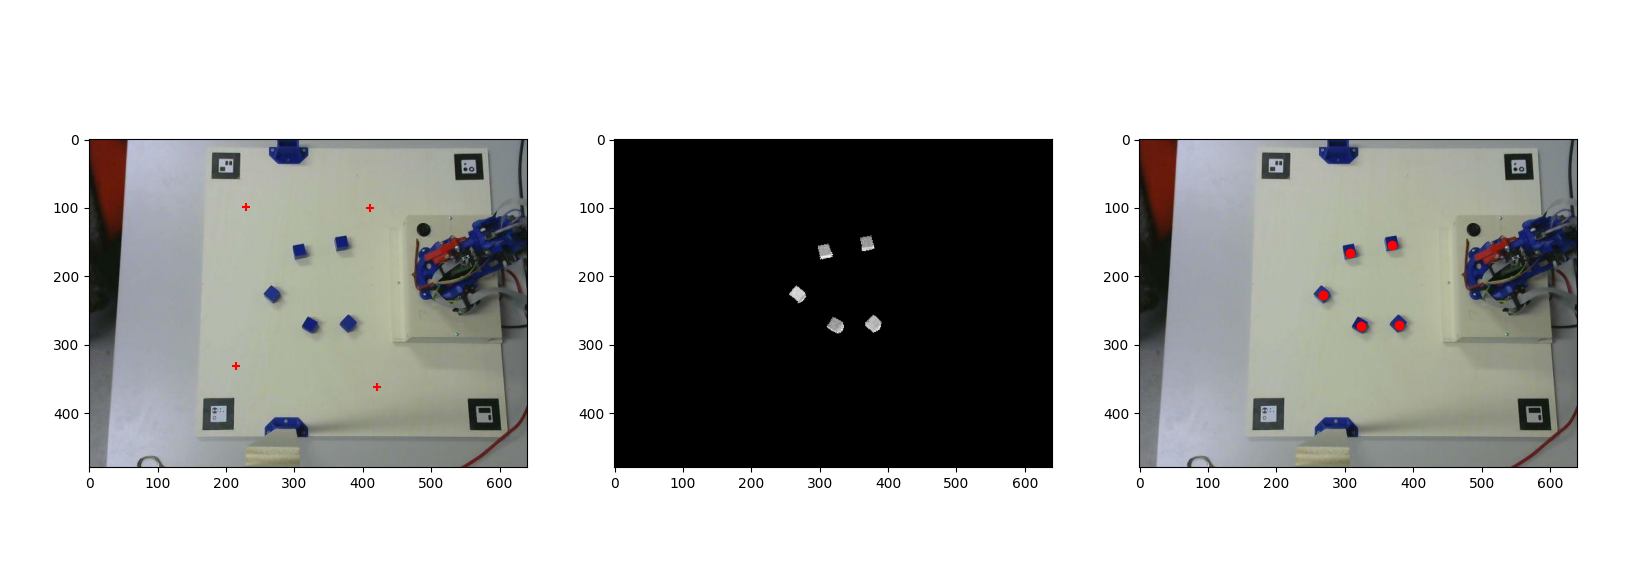

## Naloga 3 - Krmiljenje robotskega manipulatorja

Ta naloga zdru≈æeje vse znanje pridobljeno tekom prvih treh nalog. Za to nalogo morate imeti vzpostavljno virtualno okolje za uporabo manipulatorja.

* Vzpostavite sistem za dostop do manipulatorja in kamere. Preuƒçite skripto ``manus.py`` (osredotoƒçite se predvsem na class *Camera* ter funkciji ``position`` in ``image``) in si oglajte spodaj prilo≈æeno kodo, ki demonstrira kako lahko iz kamere na robotskem manipulatorju pridobimo sliko ter jo prika≈æemo na zaslonu.

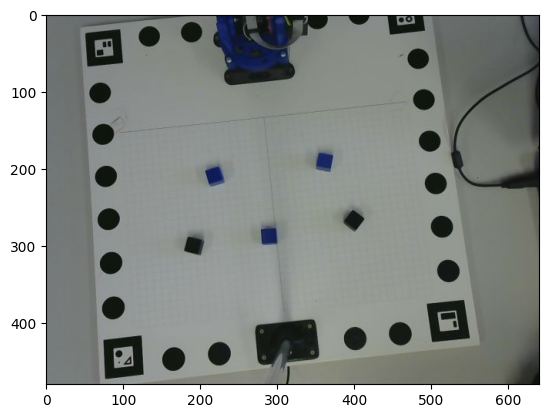

In [14]:
server = manus.Server(address='10.32.232.125', port=80)
#ip roka3: 10.32.232.119
camera = manus.Camera(server)
img = camera.image()
img_cl = cv2.cvtColor(img[0],cv2.COLOR_BGR2RGB)
#ùëùùëÜ=[ùë•,ùë¶,1],ùëùùêª=ùêª‚àóùëùùëÜ=[ùë•ùêª,ùë¶ùêª,ùëßùêª],ùëùùê∑=[ùë•ùêª/ùëßùêª,ùë¶ùêª/ùëßùêª]
#print(img)

plt.figure()
plt.imshow(img_cl)

* Z uporabo prilo≈æene funkcije ``get_homography_matrix`` preberite homografsko matriko. Homografsko matriko uporabite za izris kvadrata z $(x, y)$ koordinatami $(100, -200)$, $(100, 200)$, $(300, 200)$, $(300, -200)$ v svetovnem koordinatnem sistemu delovne ravnine.

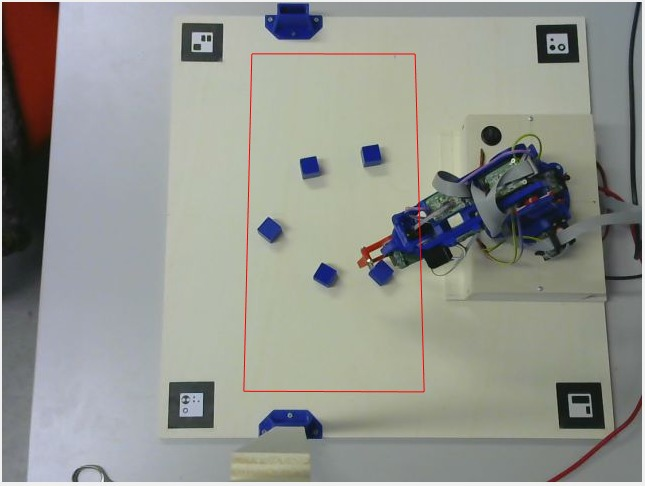

In [2]:
def get_homography_matrix(camera):
    camera_position = camera.position()
    intrinsics = camera.intrinsics
    rotation_matrix = camera_position[0]
    translation_vector = camera_position[1]
    
    transform = np.hstack((rotation_matrix, np.transpose(translation_vector)))
    projective = np.matmul(intrinsics, transform);
    homography = projective[:, [0, 1, 3]];
    homography /= homography[2, 2];
    
    return homography

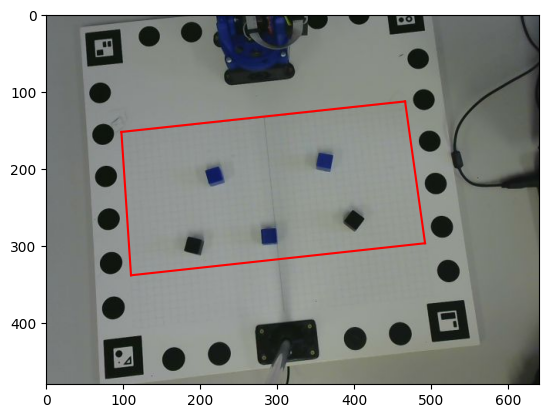

In [13]:
# TODO
#(100,‚àí200) ,  (100,200) ,  (300,200) ,  (300,‚àí200) 
server = manus.Server(address='10.32.232.125', port=80)
#ip roka3: 10.32.232.119
#ùëùùëÜ=[ùë•,ùë¶,1],ùëùùêª=ùêª‚àóùëùùëÜ=[ùë•ùêª,ùë¶ùêª,ùëßùêª],ùëùùê∑=[ùë•ùêª/ùëßùêª,ùë¶ùêª/ùëßùêª]
coords = [[100,-200],[100,200],[300,200],[300,-200]]
camera = manus.Camera(server)
img = camera.image()
img_cl = cv2.cvtColor(img[0],cv2.COLOR_BGR2RGB)
h_matrika = get_homography_matrix(camera)
y=[]
x=[]
for i in coords:
    ps = np.array([i[0],i[1],1])
    ph = np.dot(h_matrika,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    x.append(pd[0])
    y.append(pd[1])   

plt.figure()

y2= [y[0],y[3]]
x2=[x[0],x[3]]
plt.plot(x[0:2],y[0:2],"r-")
plt.plot(x[2:4],y[2:4],"r-")
plt.plot(x[1:3],y[1:3],"r-")
plt.plot(x2,y2,"r-")
plt.imshow(img_cl)


plt.show()


* Skripto raz≈°irite tako, da bo na sliki zaznala modre kocke ter prikazala njihove centroide. Po potrebi lahko doloƒçite tudi masko delovne povr≈°ine (ker je kamera v scenariju statiƒçna, lahko to masko doloƒçite enkrat ter jo potem uporabljate veƒçkrat).

(480, 640)


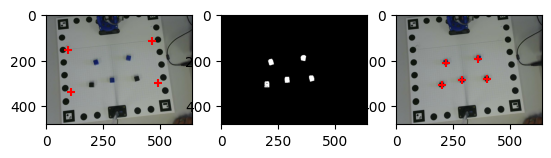

In [20]:
# TODO
from skimage import draw
import cv2
import time
import manus
import numpy as np
import matplotlib.pyplot as plt
def load_h(txt_file_path):
    with open(txt_file_path, 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]    
    return np.array(l)
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    # Zapi≈°ite re≈°itev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0   
    return I_masked
server = manus.Server(address='10.32.232.125', port=80)
manipulator = manus.Manipulator(server)
camera = manus.Camera(server)
img_c=camera.image()
img = img_c[0]
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
h = get_homography_matrix(camera)

print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
#x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
#y_c = [-200,200,200,-200]
#x_c= [100,100,300,300]
coords = [[100,-200],[100,200],[300,200],[300,-200]]
coords2 = []
for i in coords:
    ps = np.array([i[0],i[1],1])
    ph = np.dot(h,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    x_c.append(pd[0])
    y_c.append(pd[1]) 
    

#for i in x:
 #   x_c.append(i[0])
  #  y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)
imm = im_mask(im,mask)
hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>120:
            imm[i][j]=0

plt.subplot(132)
kernel = np.ones((3, 3), np.uint8)
ret,th1 = cv2.threshold(imm,20,255,cv2.THRESH_BINARY)
th1=cv2.erode(th1, kernel, iterations=1)
th1 = cv2.dilate(th1, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)


plt.imshow(th1,cmap="gray")
plt.subplot(133)




for i in range(1,len(centroids)):
    if(centroids[i][0]>np.min(np.array(x_c)) and centroids[i][0]<np.max(np.array(x_c)) and centroids[i][1]>np.min(np.array(x_c)) and centroids[i][1]<np.max(np.array(x_c))):
        plt.scatter(centroids[i][0],centroids[i][1], color = "red",marker="+")

plt.imshow(im)
plt.show()

#server = manus.Server(address='10.32.232.119', port=80)
#ip roka3: 10.32.232.119
#ùëùùëÜ=[ùë•,ùë¶,1],ùëùùêª=ùêª‚àóùëùùëÜ=[ùë•ùêª,ùë¶ùêª,ùëßùêª],ùëùùê∑=[ùë•ùêª/ùëßùêª,ùë¶ùêª/ùëßùêª]

#camera = manus.Camera(server)
#img = camera.image()



* Preslikajte vse toƒçke iz koordinatnega sistema kamere v koordinatni sistem delovne povr≈°ine. V zanki potujte preko seznama toƒçk ter manipulator premikajte tako, da bo s koncem prijemala pokazal na posamezni zaznani objekt na delovni povr≈°ini. Ker v $3D$ prostoru robotskega manipulatorja zaznane toƒçke le≈æijo na delovni povr≈°ini (koordinata v smeri $z$ je $0$) kot take niso neposredno primerne za podajanje cilja robotskemu manipulatorju. Zato toƒçko preoblikujte tako, da ji podate novo vi≈°ino od delovne povr≈°ine (npr. $z = 30$). Take toƒçke bodo od ravnine oddaljene 3 cm.

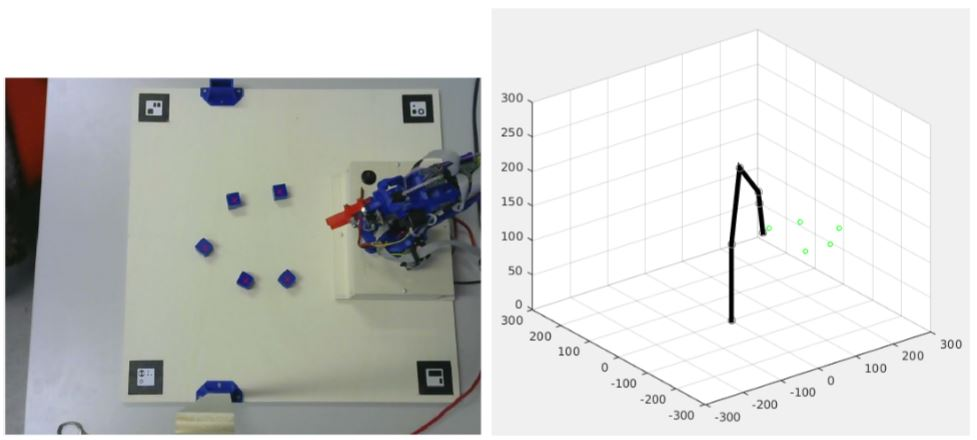

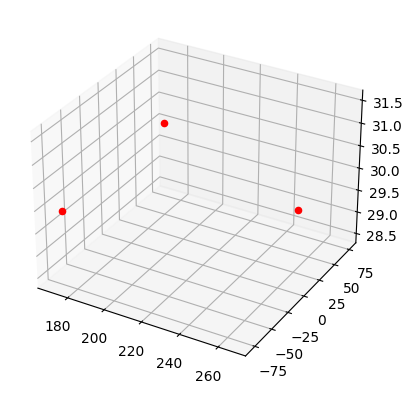

In [24]:
# TODO
from mpl_toolkits import mplot3d

from skimage import draw
import cv2
import time
import manus
import numpy as np
import matplotlib.pyplot as plt
def load_h(txt_file_path):
    with open(txt_file_path, 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]    
    return np.array(l)
def poly2mask(y_coords, x_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0   
    return I_masked
server = manus.Server(address='10.32.232.125', port=80)
manipulator = manus.Manipulator(server)
camera = manus.Camera(server)
img_c=camera.image()
img = img_c[0]
safe_position = [0.0, 2.6179938316345215, -1.5707963705062866, -1.2217304706573486, 0.0, 0.0, 0.0]

im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
h = get_homography_matrix(camera)
hi = np.linalg.inv(h)

x_c = []
y_c = []

coords = [[100,-200],[100,200],[300,200],[300,-200]]
coords2 = []


for i in coords:
    
        ps = np.array([i[0],i[1],1])
        ph = np.dot(h,ps)
        pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
        x_c.append(pd[0])
        y_c.append(pd[1]) 


mask = poly2mask(np.array(y_c),np.array(x_c),shape)
imm = im_mask(im,mask)
hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>120:
            imm[i][j]=0



kernel = np.ones((3, 3), np.uint8)
ret,th1 = cv2.threshold(imm,20,255,cv2.THRESH_BINARY)
th1=cv2.erode(th1, kernel, iterations=1)
th1 = cv2.dilate(th1, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)

for i in range(1,len(centroids)):
        ps = np.array([centroids[i][0],centroids[i][1],1])
        ph = np.dot(hi,ps)
        pd = [ph[0]/ph[2],ph[1]/ph[2],30]
        coords2.append(pd)
states=[]

fig = plt.figure()
ax = plt.axes(projection='3d')
for i in coords2:
    ax.scatter(i[0], i[1], i[2], color='red');

for i in coords2:
    state=[]
    state = manipulator.solve(i)
    states.append(state)
#manipulator.move(states[0])
#time.sleep(1)
#manipulator.move(safe_position)

for i in states:
    manipulator.move(i)
    time.sleep(2)
    manipulator.move(safe_position)


* Raz≈°irite detekcijo objektov tako, da bo zaznala kocke dveh barv, modre in ƒçrne. Manipulator naj nato poka≈æe vse zaznane modre kocke z zaprtim prijemalom, nato pa ≈°e ƒçrne kocke z odprtim prijemalom.

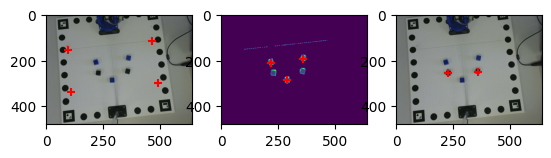

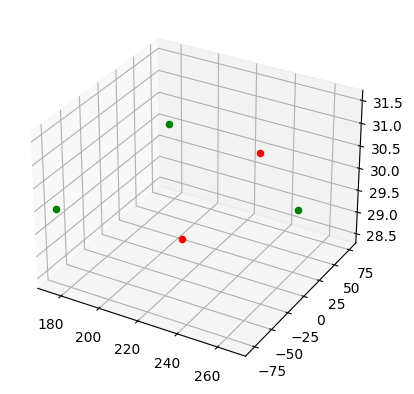

In [23]:
from skimage import draw
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
def poly2mask(y_coords, x_coords, shape):

    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):

    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0
    
    return I_masked
kernel = np.ones((3, 3), np.uint8)
server = manus.Server(address='10.32.232.125', port=80)
manipulator = manus.Manipulator(server)
camera = manus.Camera(server)
h = get_homography_matrix(camera)
img_c=camera.image()
img = img_c[0]
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape

plt.figure()
plt.subplot(131)
plt.imshow(im)
hi = np.linalg.inv(h)
x_c = []
y_c = []

coords = [[100,-200],[100,200],[300,200],[300,-200]]
coords2 = []
for i in coords:
        ps = np.array([i[0],i[1],1])
        ph = np.dot(h,ps)
        pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
        x_c.append(pd[0])
        y_c.append(pd[1]) 


plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)

imm = im_mask(im,mask)

hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
imm_b=np.copy(imm)

for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>35:
            imm_b[i][j]=0
        else:
            imm_b[i,j]=imm[i,j]

for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>120:
            imm[i][j]=0        
plt.subplot(132)

ret,th1 = cv2.threshold(imm_b,0,55,cv2.THRESH_BINARY)
th1=cv2.erode(th1, kernel, iterations=1)
th1 = cv2.dilate(th1, kernel, iterations=1)
ret2,th2 = cv2.threshold(imm,0,55,cv2.THRESH_BINARY)
th2=cv2.erode(th2, kernel, iterations=1)
th2 = cv2.dilate(th2, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)
num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(th2)
f =False
blu_man = []
blk_man = []
for i in range(1,len(centroids2)):
    for j in range(1,len(centroids)):
        if(abs(centroids2[i][0]-centroids[j][0])<10 and abs(centroids2[i][1]-centroids[j][1])<10):
            f = True
    if f:
        f=False
        continue
    plt.scatter(centroids2[i][0],centroids2[i][1], color = "red",marker="+")
    blu_man.append([centroids2[i][0],centroids2[i][1]])

plt.imshow(imm)

plt.subplot(133)
for i in range(1,len(centroids)):
    plt.scatter(centroids[i][0],centroids[i][1], color = "red",marker="+")
    blk_man.append([centroids[i][0],centroids[i][1]])
for i in range(0,len(blk_man)):
        ps = np.array([blk_man[i][0],blk_man[i][1],1])
        ph = np.dot(hi,ps)
        pd = [ph[0]/ph[2],ph[1]/ph[2],30]
        coords2.append(pd)
coords3=[]
for i in range(0,len(blu_man)):
        ps = np.array([blu_man[i][0],blu_man[i][1],1])
        ph = np.dot(hi,ps)
        pd = [ph[0]/ph[2],ph[1]/ph[2],30]
        coords3.append(pd)
states_blu=[]
states_blk=[]

safe_position_o = [0.0, 2.6179938316345215, -1.5707963705062866, -1.2217304706573486, 0.0, 0.0, 0.0]
safe_position_c = [0.0, 2.6179938316345215, -1.5707963705062866, -1.2217304706573486, 0.0, 0.0, 2.0]
for i in coords2:
    state=[]
    state = manipulator.solve(i)
    states_blk.append(state)
for i in coords3:
    state=[]
    state = manipulator.solve(i)
    state[len(state)-1]=2
    states_blu.append(state)

for i in states_blu:
    manipulator.move(i)
    time.sleep(2)
    manipulator.move(safe_position_c)
for i in states_blk:
    manipulator.move(i)
    time.sleep(2)
    manipulator.move(safe_position_o)
    
plt.imshow(im)
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in coords2:
    ax.scatter(i[0], i[1], i[2], color='red');
for i in coords3:
    ax.scatter(i[0], i[1], i[2], color='green');
plt.show()

* **(5 toƒçk)** Napi≈°ite algoritem, ki bo krmilil manipulator tako, da bo sledil izbranemu predmetu preko kamere. Pri tem lahko predpostavite, da je predmet blizu delovne povr≈°ine (z = 0), lahko si tudi izberete njegovo barvo ali druge lastnosti.

In [ ]:
# TODO

* **(10 toƒçk)** Prilagodite algoritem iz prej≈°njih toƒçk tako, da bo manipulator zaznane kocke dveh barv (si lahko izberete vnaprej), ki so na zaƒçetku razporejene nakljuƒçno, razporedil glede na barvo na levo in desno stran delovne povr≈°ine. Pri tem bodite pozorni, da kocke ne bodo postavljene ena ƒçez drugo.

In [ ]:
# TODO

* **(10 toƒçk)** Prilagodite algoritem iz prej≈°njih toƒçk tako, da bo manipulator zaznane kocke (vsaj ≈°tiri kocke) zlo≈æil eno na drugo v stolp. 